In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import numpy as np
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask, interpolation, reshape
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.evaluation_functions import baseline_evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
mr_data_path='input_data/deg/0_5x0_5/'
hr_data_path='input_data/deg/0_25x0_25/'
global_mean = 286.307980744908
global_Std = 64.2568020375484

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K

# Custom PSNR Metric
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * tf.math.log(max_pixel ** 2 / (K.mean(K.square(y_pred - y_true)))) / tf.math.log(10.0)

# Custom SSIM Metric
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Function to compute mean PSNR and mean SSIM
def compute_mean_psnr_ssim(dataset1, dataset2):
    """
    dataset1: List or NumPy array of original images
    dataset2: List or NumPy array of reconstructed images
    """
    num_images = len(dataset1)
    total_psnr = 0.0
    total_ssim = 0.0

    for img1, img2 in zip(dataset1, dataset2):
        img1_tensor = tf.convert_to_tensor(img1, dtype=tf.float32)
        img2_tensor = tf.convert_to_tensor(img2, dtype=tf.float32)

        total_psnr += psnr(img1_tensor, img2_tensor).numpy()
        total_ssim += ssim(img1_tensor, img2_tensor).numpy()

    mean_psnr = total_psnr / num_images
    mean_ssim = total_ssim / num_images

    return mean_psnr, mean_ssim



In [4]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

# **Bicubic**

In [5]:
upsampled_data = []
for img in testX:
    upsampled_img = interpolation(np.squeeze(img), (320, 580))
    upsampled_data.append(upsampled_img)

hr_data_bicubic = np.array(upsampled_data)
hr_data_bicubic =reshape(hr_data_bicubic)

In [6]:
bicubic_test_mse, bicubic_test_mae, bicubic_test_psnr, bicubic_test_ssim = baseline_evaluate_per_pixel(hr_data_bicubic, testY, max_pixel=1.0)

In [7]:
print("Per-pixel MSE shape:", bicubic_test_mse.shape)
print("Per-pixel MAE shape:", bicubic_test_mae.shape)
print("Per-pixel PSNR shape:", bicubic_test_psnr.shape)
print("Per-pixel SSIM shape:", bicubic_test_ssim.shape)

bicubic_mean_mse = np.mean(bicubic_test_mse)
bicubic_mean_mae = np.mean(bicubic_test_mae)
bicubic_mean_psnr = np.mean(bicubic_test_psnr)
bicubic_mean_ssim = np.mean(bicubic_test_ssim)

print("Mean Per-Pixel MSE:", bicubic_mean_mse)
print("Mean Per-Pixel MAE:", bicubic_mean_mae)
print("Mean Per-Pixel PSNR:", bicubic_mean_psnr)
print("Mean Per-Pixel SSIM:", bicubic_mean_ssim)

Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 0.00016450239584827025
Mean Per-Pixel MAE: 0.006072624870891618
Mean Per-Pixel PSNR: 46.659295854460574
Mean Per-Pixel SSIM: 0.9821501926088599


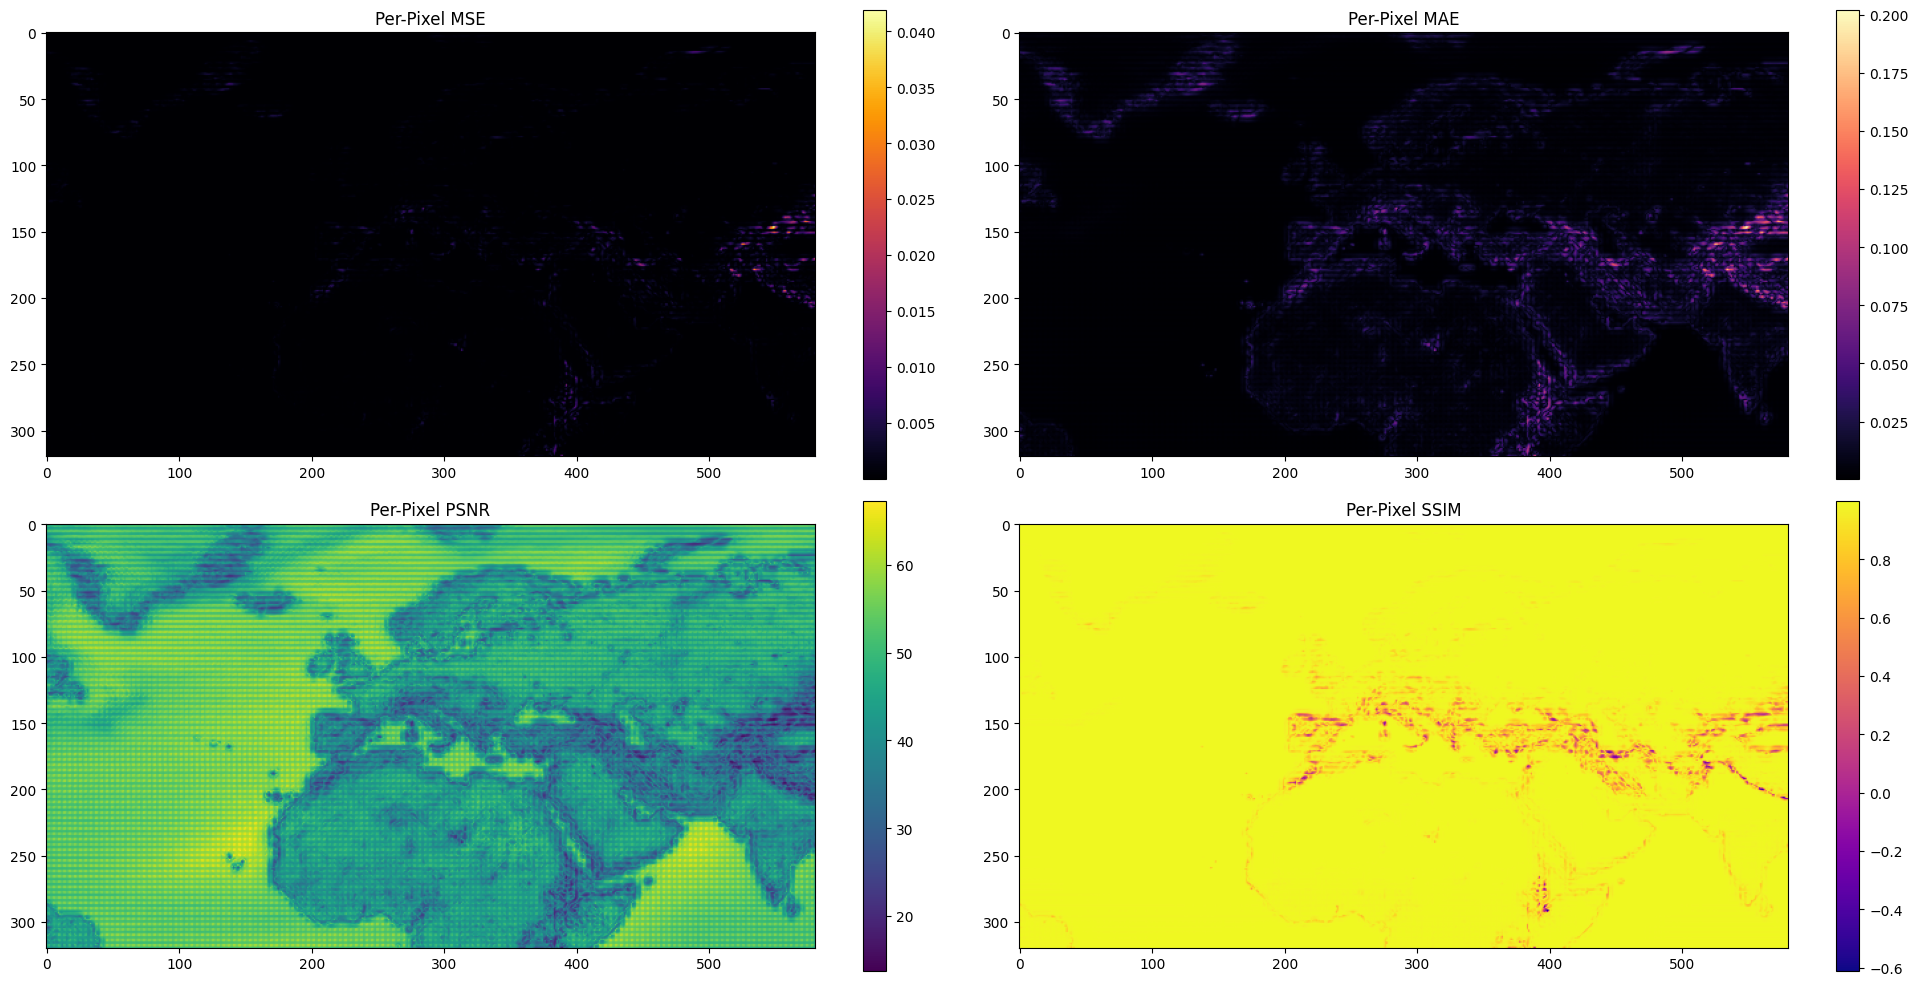

In [8]:
plot_per_pixel_metrics(bicubic_test_mse, bicubic_test_mae, bicubic_test_psnr, bicubic_test_ssim)

Mean Per-Pixel Degrees MAE: 0.39020745417717556
Max Degrees MAE: 12.991224134401165
Min Degrees MAE: 0.019688422719924385


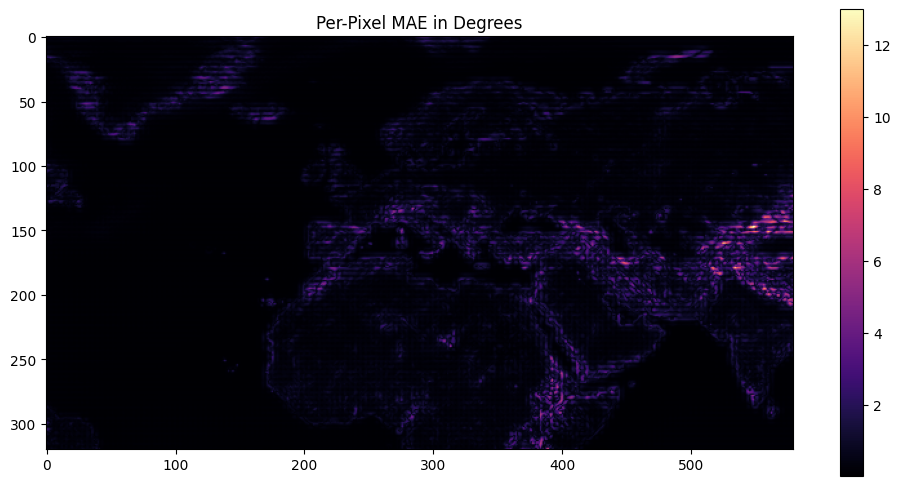

In [9]:
bicubic_degrees_mae = denormalize_mae(bicubic_test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(bicubic_degrees_mae))
print("Max Degrees MAE:", bicubic_degrees_mae.max())
print("Min Degrees MAE:", bicubic_degrees_mae.min())
plot_degrees_mae(bicubic_degrees_mae)

In [10]:
bicubic_mean_psnr, bicubic_mean_ssim = compute_mean_psnr_ssim(hr_data_bicubic, testY)
print(f"Mean PSNR: {bicubic_mean_psnr:.4f}, Mean SSIM: {bicubic_mean_ssim:.4f}")

Mean PSNR: 37.8830, Mean SSIM: 0.9493


In [11]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(bicubic_degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(bicubic_test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 0.606649444430561
Mean Land-Pixels MAE: 0.009441015195186123


In [12]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(bicubic_degrees_mae, '0_25'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(bicubic_test_mae, '0_25'))

Mean Coastline-Pixels Degrees MAE: 0.8522685258962175
Mean Costline-Pixels MAE: 0.01326347559902211


# **Nearest neighbor**

In [13]:
import cv2
upsampled_data = []
for img in testX:
    upsampled_img = cv2.resize(np.squeeze(img), (580, 320), interpolation=cv2.INTER_NEAREST)
    upsampled_data.append(upsampled_img)

hr_data_nearest = np.array(upsampled_data)
hr_data_nearest =reshape(hr_data_nearest)

In [14]:
nearest_test_mse, nearest_test_mae, nearest_test_psnr, nearest_test_ssim = baseline_evaluate_per_pixel(hr_data_nearest, testY, max_pixel=1.0)

In [15]:
print("Per-pixel MSE shape:", nearest_test_mse.shape)
print("Per-pixel MAE shape:", nearest_test_mae.shape)
print("Per-pixel PSNR shape:", nearest_test_psnr.shape)
print("Per-pixel SSIM shape:", nearest_test_ssim.shape)

nearest_mean_mse = np.mean(nearest_test_mse)
nearest_mean_mae = np.mean(nearest_test_mae)
nearest_mean_psnr = np.mean(nearest_test_psnr)
nearest_mean_ssim = np.mean(nearest_test_ssim)

print("Mean Per-Pixel MSE:", nearest_mean_mse)
print("Mean Per-Pixel MAE:", nearest_mean_mae)
print("Mean Per-Pixel PSNR:", nearest_mean_psnr)
print("Mean Per-Pixel SSIM:", nearest_mean_ssim)

Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 0.0003365852483587405
Mean Per-Pixel MAE: 0.00903604306637072
Mean Per-Pixel PSNR: 42.69684625392844
Mean Per-Pixel SSIM: 0.9707388543702241


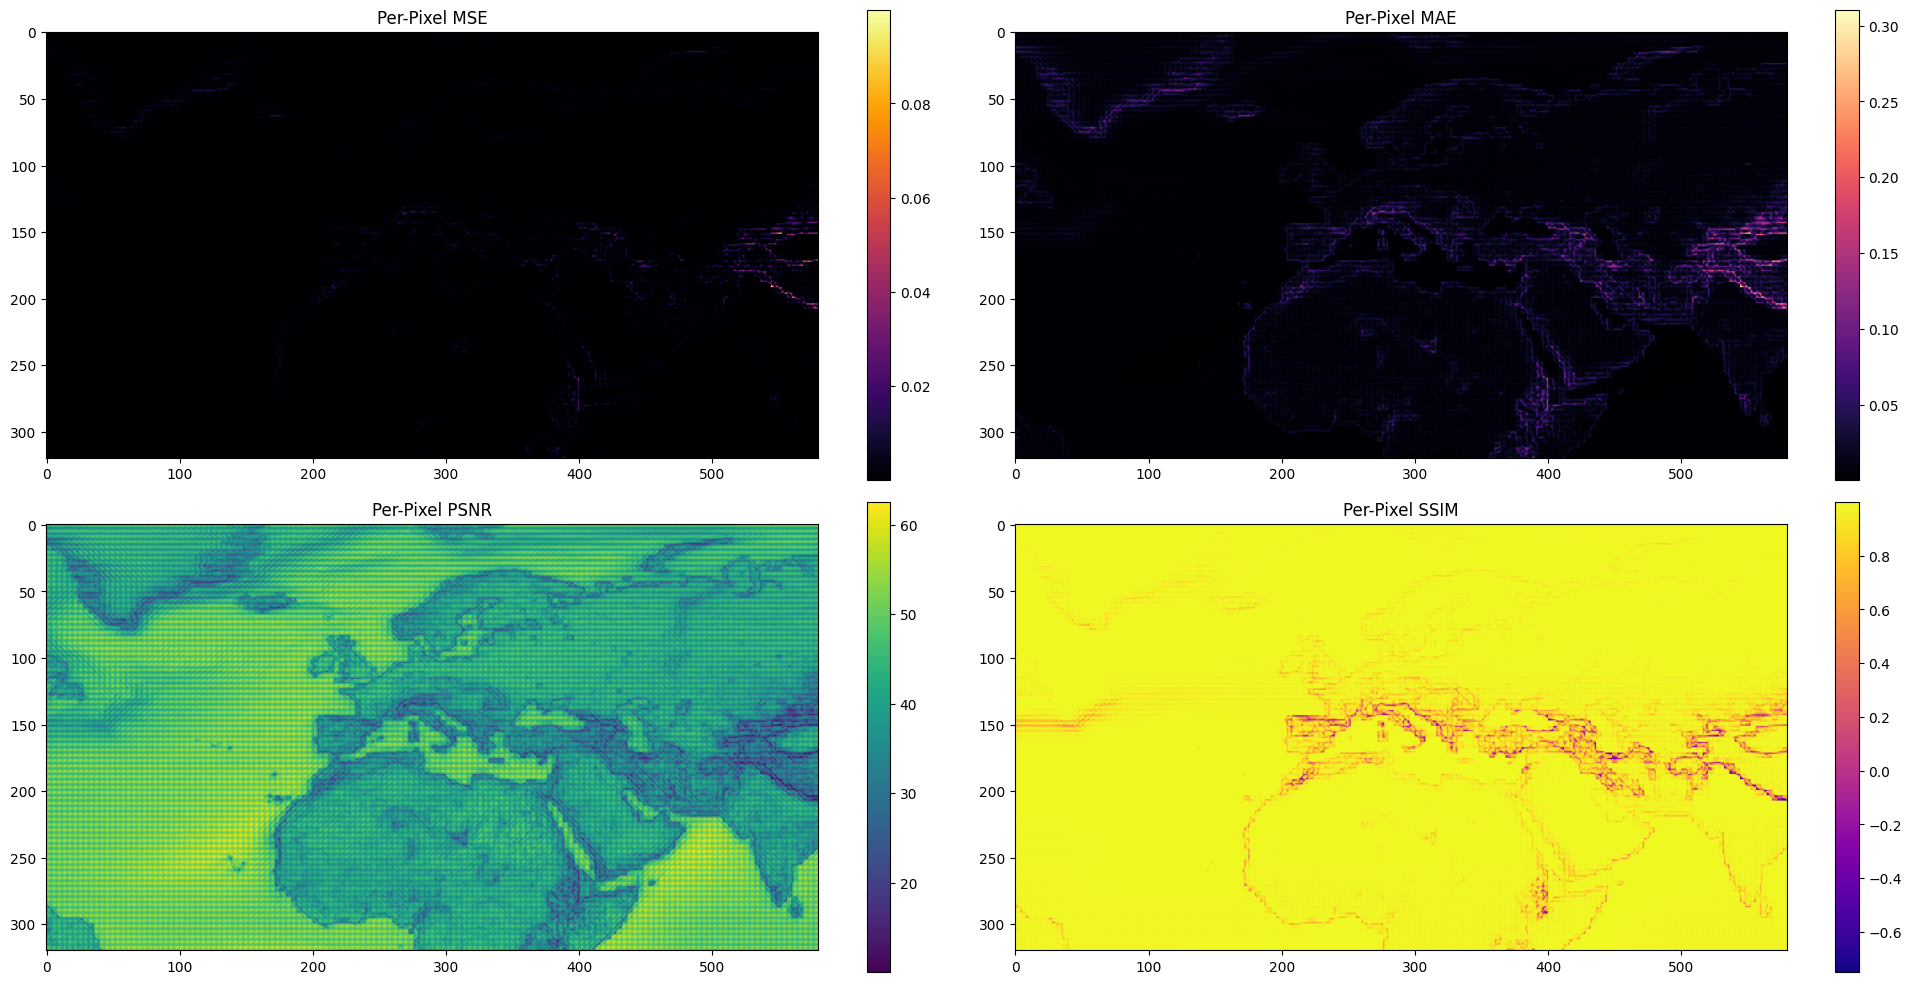

In [16]:
plot_per_pixel_metrics(nearest_test_mse, nearest_test_mae, nearest_test_psnr, nearest_test_ssim)

Mean Per-Pixel Degrees MAE: 0.580627230518545
Max Degrees MAE: 19.958141885905775
Min Degrees MAE: 0.036254789596298444


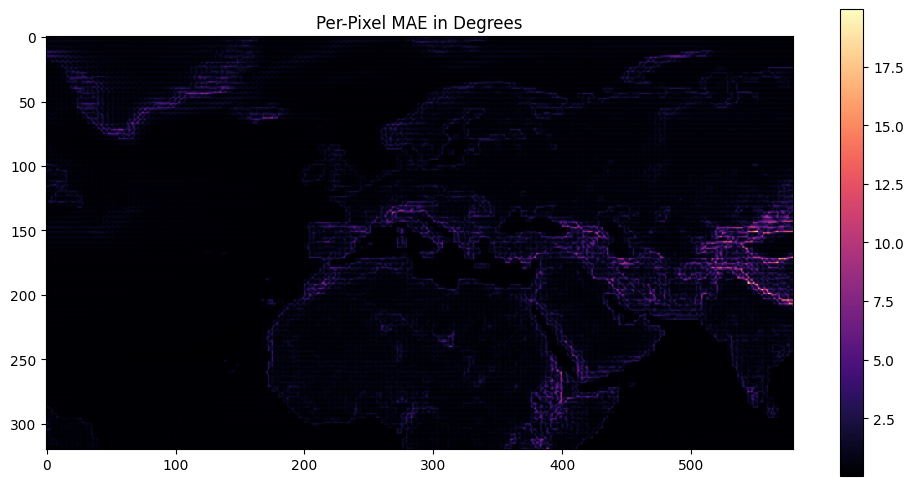

In [17]:
nearest_degrees_mae = denormalize_mae(nearest_test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(nearest_degrees_mae))
print("Max Degrees MAE:", nearest_degrees_mae.max())
print("Min Degrees MAE:", nearest_degrees_mae.min())
plot_degrees_mae(nearest_degrees_mae)

In [18]:
nearest_mean_psnr, nearest_mean_ssim = compute_mean_psnr_ssim(hr_data_nearest, testY)
print(f"Mean PSNR: {nearest_mean_psnr:.4f}, Mean SSIM: {nearest_mean_ssim:.4f}")

Mean PSNR: 34.7709, Mean SSIM: 0.9058


In [19]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(nearest_degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(nearest_test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 0.878714520962151
Mean Land-Pixels MAE: 0.013675042845248895


In [20]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(nearest_degrees_mae, '0_25'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(nearest_test_mae, '0_25'))

Mean Coastline-Pixels Degrees MAE: 1.2884437189414408
Mean Costline-Pixels MAE: 0.020051475922946493


# **Bias Correction**

In [21]:
import cv2

def caclulate_bias(lr_data, hr_data):
  bias = np.zeros((320, 580))
  for img1, img2 in zip(lr_data, hr_data):
      upsampled_img = cv2.resize(np.squeeze(img1), (580, 320), interpolation=cv2.INTER_NEAREST)
      bias += upsampled_img - np.squeeze(img2)
  bias /= len(lr_data)
  return bias

In [22]:
bias = caclulate_bias(trainX, trainY)

In [23]:
bias_res_data = hr_data_nearest + bias[np.newaxis, :, :, np.newaxis]

In [24]:
bias_test_mse, bias_test_mae, bias_test_psnr, bias_test_ssim = baseline_evaluate_per_pixel(bias_res_data, testY, max_pixel=1.0)

In [25]:
print("Per-pixel MSE shape:", bias_test_mse.shape)
print("Per-pixel MAE shape:", bias_test_mae.shape)
print("Per-pixel PSNR shape:", bias_test_psnr.shape)
print("Per-pixel SSIM shape:", bias_test_ssim.shape)

bias_mean_mse = np.mean(bias_test_mse)
bias_mean_mae = np.mean(bias_test_mae)
bias_mean_psnr = np.mean(bias_test_psnr)
bias_mean_ssim = np.mean(bias_test_ssim)

print("Mean Per-Pixel MSE:", bias_mean_mse)
print("Mean Per-Pixel MAE:", bias_mean_mae)
print("Mean Per-Pixel PSNR:", bias_mean_psnr)
print("Mean Per-Pixel SSIM:", bias_mean_ssim)

Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 0.0009151611472265238
Mean Per-Pixel MAE: 0.013823333001040274
Mean Per-Pixel PSNR: 40.847338105044486
Mean Per-Pixel SSIM: 0.9498442951499927


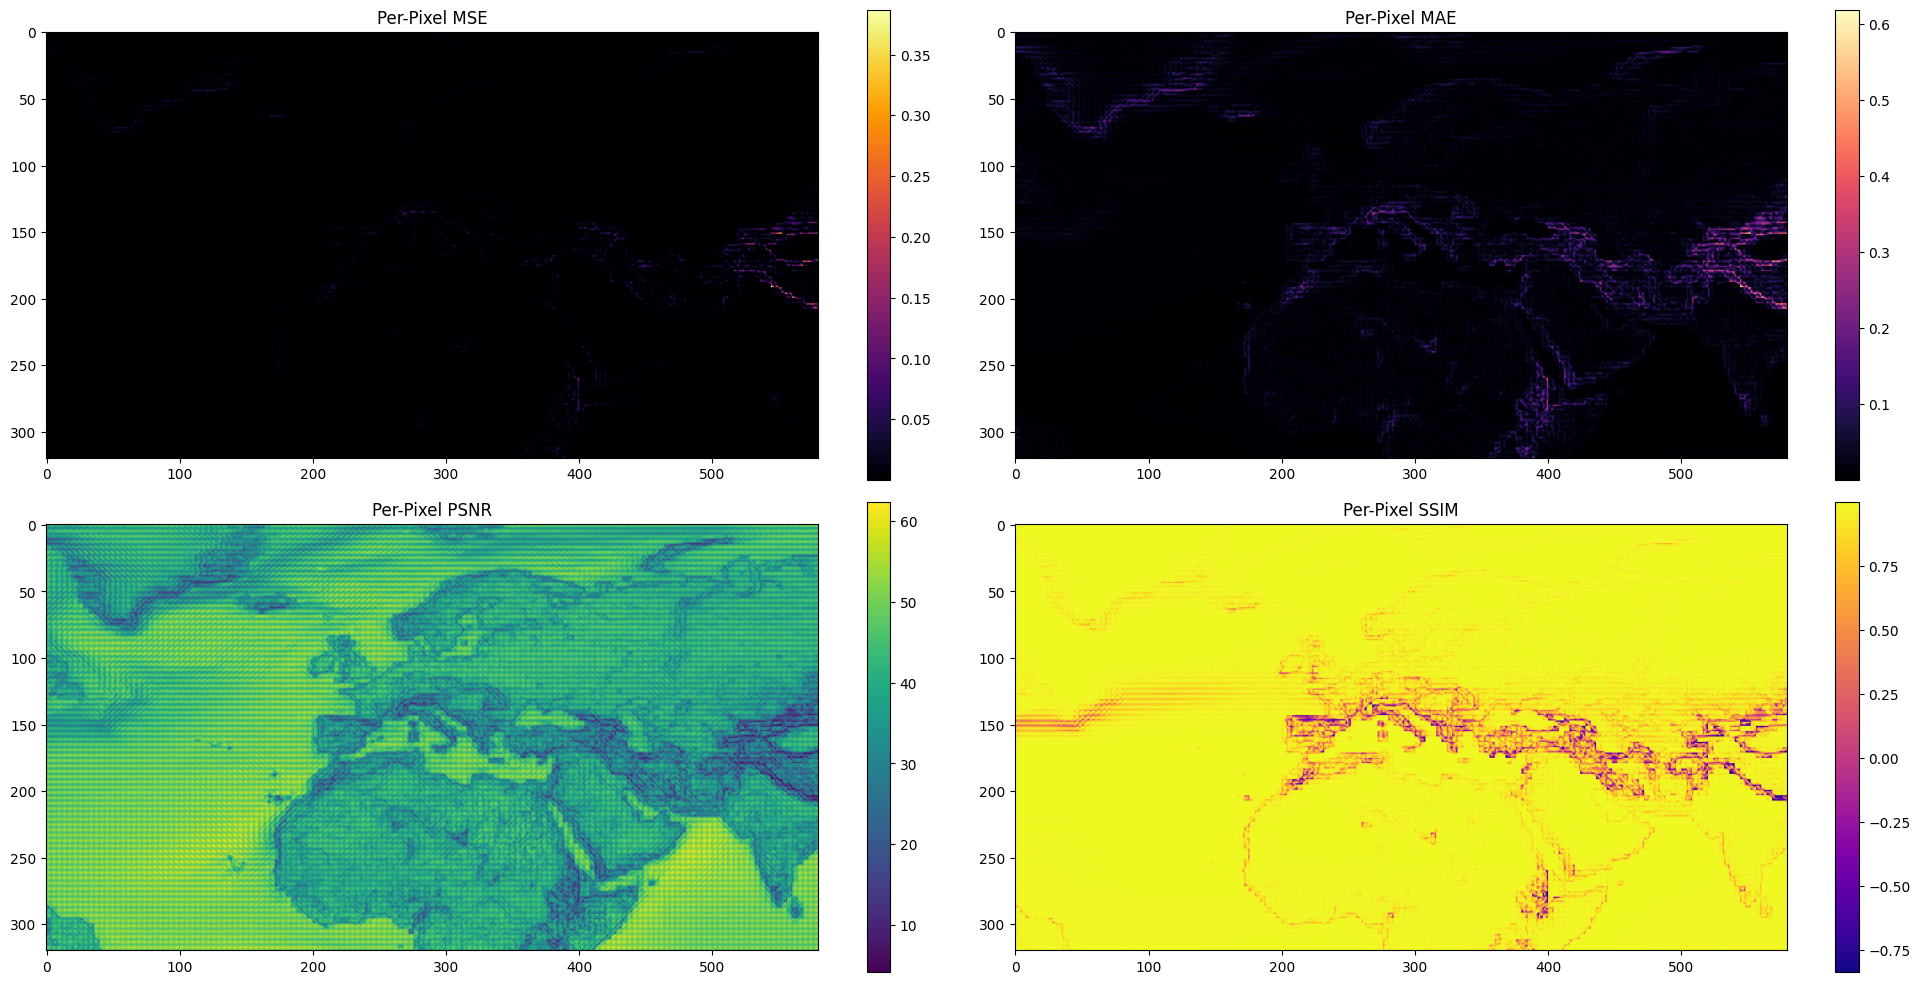

In [26]:
plot_per_pixel_metrics(bias_test_mse, bias_test_mae, bias_test_psnr, bias_test_ssim)

In [27]:
bias_mean_psnr, bias_mean_ssim = compute_mean_psnr_ssim(bias_res_data, testY)
print(f"Mean PSNR: {bias_mean_psnr:.4f}, Mean SSIM: {bias_mean_ssim:.4f}")

Mean PSNR: 30.3939, Mean SSIM: 0.8257


Mean Per-Pixel Degrees MAE: 0.8882431721469548
Max Degrees MAE: 39.798182967067746
Min Degrees MAE: 0.036775685283670284


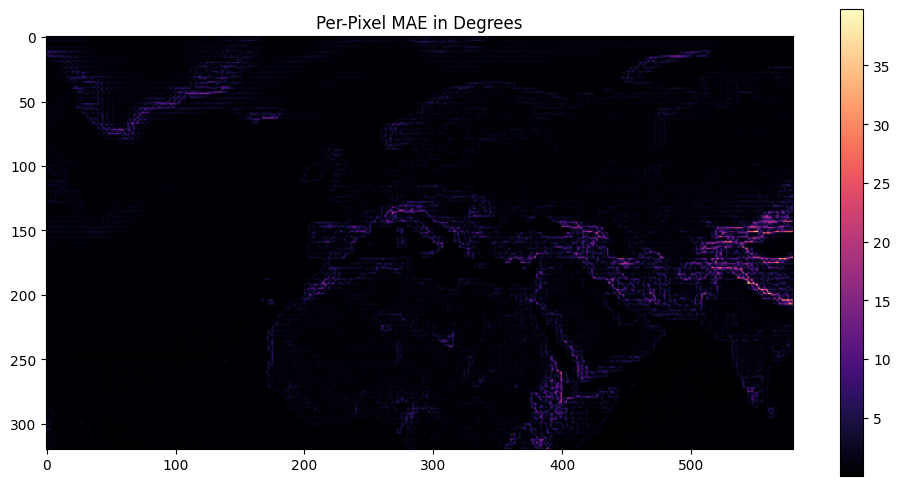

In [28]:
bias_degrees_mae = denormalize_mae(bias_test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(bias_degrees_mae))
print("Max Degrees MAE:", bias_degrees_mae.max())
print("Min Degrees MAE:", bias_degrees_mae.min())
plot_degrees_mae(bias_degrees_mae)

In [29]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(bias_degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(bias_test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 1.381654112055645
Mean Land-Pixels MAE: 0.02150206776939003


In [30]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(bias_degrees_mae, '0_25'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(bias_test_mae, '0_25'))

Mean Coastline-Pixels Degrees MAE: 1.7466840083193989
Mean Costline-Pixels MAE: 0.027182865516692314
